<a href="https://colab.research.google.com/github/ddopp4877/single-cell-tuning/blob/main/test_cell_with_syns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade numpy==1.24.4 pandas==2.2.2 scipy==1.11.3> /dev/null 2>&1

import os
os.kill(os.getpid(), 9)#restart so the above packages can be used

In [1]:
# If running in Colab
!pip install --upgrade pip2 > /dev/null 2>&1
!pip install --quiet allensdk neuron > /dev/null 2>&1
!git clone -b release_candidate https://github.com/V-Marco/ACT.git > /dev/null 2>&1

In [2]:
!pip install --quiet allensdk neuron

In [3]:
# Mouse L2/3 SST (Som) cell
# http://celltypes.brain-map.org/mouse/experiment/electrophysiology/476686112
#Mouse L2/3 Pyr
#https://celltypes.brain-map.org/experiment/electrophysiology/477127614
specimen_id = 476686112
model_type = 'perisomatic'#or 'all active'
work_dir = 'OriginalFromAllenDB'

In [4]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("ACT")
from act.passive import ACTPassiveModule

In [5]:
from allensdk.api.queries.biophysical_api import BiophysicalApi
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical.utils import Utils

In [6]:
#get the model id

bp = BiophysicalApi()#using AllenDB's API
models = bp.get_neuronal_models(specimen_id)

for model in models:
  if model_type in model['name'].lower():
    print(f"model id = {model['id']}\n")
    model_id = model['id']
models

model id = 477878284



[{'id': 477878284,
  'name': 'Biophysical - perisomatic_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 329230710,
  'specimen_id': 476686112},
 {'id': 497232660,
  'name': 'Biophysical - all active_Sst-IRES-Cre;Ai14-188740.03.02.01',
  'neuron_reconstruction_id': 491119369,
  'neuronal_model_template_id': 491455321,
  'specimen_id': 476686112}]

In [7]:
# Download the cell
bp.cache_stimulus = False # Change to False to not download the large stimulus NWB file
bp.cache_data(model_id, working_directory = work_dir )
os.chdir(work_dir)

2025-06-03 23:11:27,721 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210401
2025-06-03 23:11:28,021 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/657210404
2025-06-03 23:11:28,119 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
INFO:allensdk.api.api.retrieve_file_over_http:Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/395337293
2025-06-03 23:11:28,215 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_fi

In [8]:
filenames = os.listdir('modfiles')
# Directory path
dir_path = "modfiles"

# List all files in the directory
for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)

    # Check if it is a file (not a subdirectory)
    if os.path.isfile(file_path):
        os.remove(file_path)  # Remove the file
        # print(f"Deleted file: {filename}")

In [9]:
import requests
path = "https://raw.githubusercontent.com/cyneuro/single-cell-tuning/main/Segregated/modfiles"

for filename in filenames:

  url = os.path.join(path,filename)
  response = requests.get(url)

  if response.status_code == 200:
      with open(os.path.join('modfiles',filename), 'w') as f:#assuming you are in work_dir and the mechanisms are in a folder called 'modflies'
          f.write(response.text)
  else:
      print(f"Failed to download file: {response.status_code}")

In [10]:
import requests
path = "https://raw.githubusercontent.com/yzerlaut/pv-sst-dendrites/main/detailed_model/mechanisms"
filenames = ['NMDAIN.mod','vecstim.mod','cpampain.mod', 'gabaain.mod']

for filename in filenames:

  url = os.path.join(path,filename)
  response = requests.get(url)

  if response.status_code == 200:
      with open(os.path.join('modfiles',filename), 'w') as f:#assuming you are in work_dir and the mechanisms are in a folder called 'modflies'
          f.write(response.text)
  else:
      print(f"Failed to download file: {response.status_code}")

In [11]:
# Compile the modfiles

!nrnivmodl modfiles > /dev/null 2>&1

In [12]:
import sys, os
from functools import wraps

def suppress_output(fn):
    @wraps(fn)
    def wrapper(*args, **kwargs):
        devnull = open(os.devnull, 'w')
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout = sys.stderr = devnull
        try:
            return fn(*args, **kwargs)
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr
            devnull.close()
    return wrapper

In [13]:
@suppress_output
def build_cell(soma_diam_multiplier = 1,using_hoc=False,hoc_filename=None,cell_name=None):

    if using_hoc:
      from neuron import h
      h.load_file(hoc_filename)
      return getattr(h, cell_name)()
    # Create the h object
    description = Config().load('manifest.json')
    utils = Utils(description)
    h = utils.h
    # Convert all "value" attributes to floats
    for dict in utils.description.data['genome']:
        for key, value in dict.items():
            if key == 'value': dict[key] = float(value)
    # Configure morphology
    morphology_path = description.manifest.get_path('MORPHOLOGY')
    utils.generate_morphology(morphology_path.encode('ascii', 'ignore'))
    utils.load_cell_parameters()
    # To match PP
    h.soma[0].diam = h.soma[0].diam * soma_diam_multiplier

    return h

In [21]:
from neuron import h
h.load_file("stdrun.hoc")  # Required to use h.run()



1.0

#Automated

In [22]:
def create_syns(h,syn_point_proc, seg,dend_sec_no, nsyn):
  syns =  [syn_point_proc(seg, h.dend[int(dend_sec_no)]) for i in range(nsyn)]
  return syns

In [23]:
def insert_syns(h,sim_params,name):

  nsyns = len(sim_params["event_times"])#one event per synapse

  point_proc_name = f"{name}_point_proc"

  seg = sim_params[f"{name}_seg"]
  sec = sim_params[f"{name}_sec"]

  syns = create_syns(h,sim_params[point_proc_name],seg,sec,nsyns)
  vec_stims = [h.VecStim() for i in range(nsyns)]
  event_times_vectors = [h.Vector(sim_params["event_times"][i]) for i in range(nsyns)]

  ncs = []
  for i in range(nsyns):
    vec_stims[i].play(event_times_vectors[i])
    nc = h.NetCon(vec_stims[i],syns[i])
    nc.weight[0] = sim_params[f"{name}_weight"]
    ncs.append(nc)

  return_dict = {"nsyns": nsyns,
                  "syns": syns,
                  "vec_stims": vec_stims,
                  "event_times_vectors":event_times_vectors,
                  "ncs":ncs}

  return return_dict


create inputs for 4 E

In [ ]:
# h = build_cell(1)

In [22]:
# sec_path = [27,28,31,32,33]

# sec_seg_list = []
# for sec in sec_path:
#   for seg in h.dend[sec]:
#     pair = (sec,seg.x)
#     sec_seg_list.append(pair)

In [ ]:
#for each seg in a section, calc the dist from the soma and lookup linear density from there.
#then multiply by the len of the segment and that's the number of synapses to place in the section

15

In [16]:
def get_rec_vars_for_i_in_sec(sec,seg):#create recording variables for every current in a section
  current_recording_vars = {}

  for mech in sec.psection()['density_mechs']:
    for param in sec.psection()['density_mechs'][mech]:
      if param[0] == 'i':#assumes only current names start with i
        attr = getattr(sec(seg),mech)
        ref = getattr(attr, f"_ref_{param}")
        current_recording_vars[f"{mech}.{param}"] = h.Vector().record(ref)

  return current_recording_vars


In [17]:
def run(h,sim_params):

  nsyns = len(sim_params["event_times"])#one event per synapse

  ampa_return_dict = insert_syns(h,sim_params,'ampa')
  nmda_return_dict = insert_syns(h,sim_params,'nmda')

  #### Recording Variables ####
  # v = h.Vector().record(h.dend[33](0.67)._ref_v)# to check nmda effect
  v = h.Vector().record(h.soma[0](0.5)._ref_v)
  current_recording_vars = get_rec_vars_for_i_in_sec(h.soma[0],0.5)
  # ampa_currents = []
  # for syn in ampa_return_dict["syns"]:
  #     ampa_currents.append(h.Vector().record(syn._ref_ica))

  ### RUN ###
  h.finitialize()
  h.dt=sim_params["h_dt"]
  h.tstop = sim_params["h_tstop"]
  h.run()


  recordings_dict = {"v": v.as_numpy(),
                     "sec_currents": current_recording_vars,
                     "ampa": ampa_return_dict["syns"]}

  return recordings_dict

In [46]:
def plot(rec_dict,title,real_or_expected="real"):
  V = rec_dict["v"]

  tstart = sim_params["event_times"][0][0]-500
  tstop = tstart +50
  vrest = np.mean(V[tstart:tstop])
  corrected_v = V-vrest
  corrected_v = np.array(corrected_v)

  start, end = int(sim_params["event_times"][0][0]/sim_params["h_dt"] - 500), int(sim_params["event_times"][0][0]/sim_params["h_dt"] + 5000)
  real = corrected_v[start:end]

  if real_or_expected.lower() == "expected":
    real = real*3

  times = np.arange(0,sim_params["h_tstop"]+sim_params["h_dt"],sim_params["h_dt"])
  t = times[start:end]
  # plt.ylim([-1,10])
  plt.plot(t,real)
  plt.title(title)

  plt.show()
  return real

In [19]:
def plot_currents(rec_dict):
  currents = rec_dict["sec_currents"]
  colors = plt.cm.tab20.colors  # 20 distinct colors
  i = 0
  for current in currents:
    plt.plot(currents[current].as_numpy(),color = colors[i],label = current)
    i+=1
  plt.legend()

#proximal

real

In [84]:

ampa_weight = 0.00015
nmda_weight = ampa_weight*1.5

sim_params = {"event_times":[[400],[400.5],[401]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "h_dt": 0.025,
              "h_tstop": 1000

              }

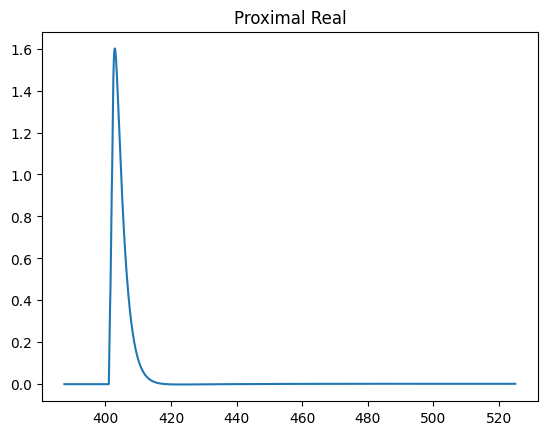

In [85]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
real = plot(rec_dict,"Proximal Real","Real")



expected

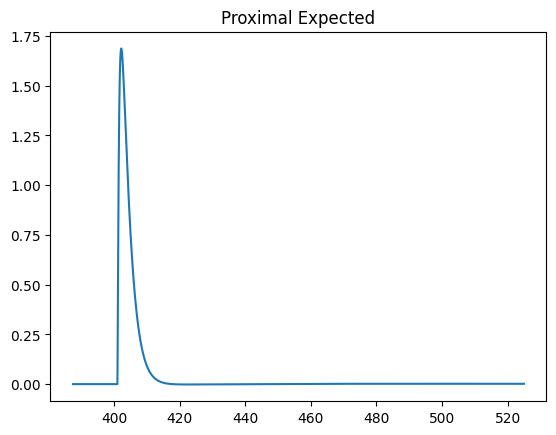

In [86]:
ampa_weight = 0.00015
nmda_weight = ampa_weight*1.5

sim_params = {"event_times":[[400]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "h_dt": 0.025,
              "h_tstop": 1000

              }

h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
expected = plot(rec_dict,"Proximal Expected","Expected")

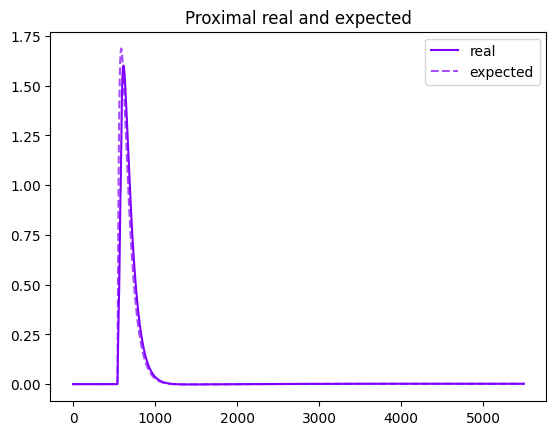

In [87]:
plt.plot(real,color = "#7F00FF",label="real")
plt.plot(expected,color="#7F00FF",linestyle = "dashed",alpha = 0.7,label="expected")
plt.legend()
plt.title("Proximal real and expected")
plt.show()

# Proximal Real No NMDA

In [88]:

ampa_weight = 0.00015
nmda_weight = 0

sim_params = {"event_times":[[400],[400.5],[401]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "h_dt": 0.025,
              "h_tstop": 1000
              }

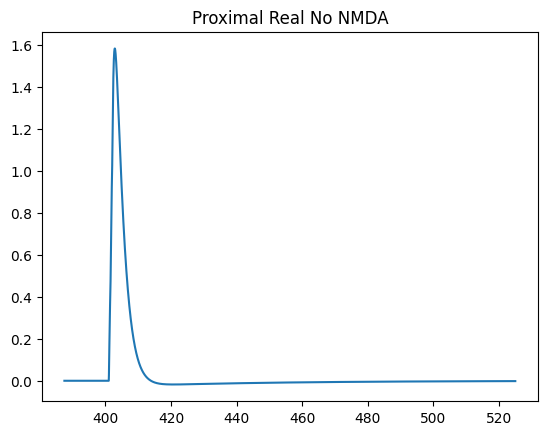

In [89]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
real = plot(rec_dict,"Proximal Real No NMDA","Real")

# Proximal Expected No NMDA

In [90]:
nsyn_exc = int(40 *.04 * 2)
ampa_weight = 0.00015
nmda_weight = 0

sim_params = {"event_times":[[400]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.5,
              "ampa_sec": 32,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.5,
              "nmda_sec": 32,

              "h_dt": 0.025,
              "h_tstop": 1000

              }

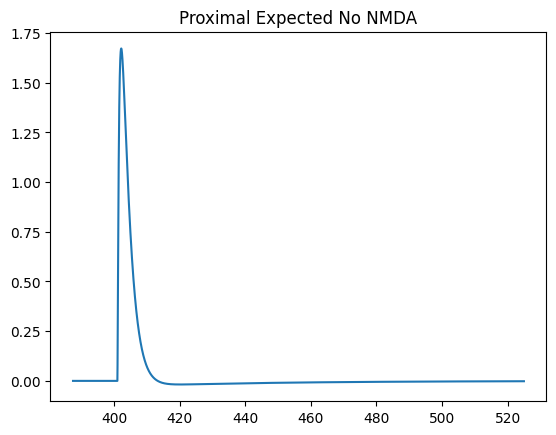

In [91]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
expected = plot(rec_dict,"Proximal Expected No NMDA","Expected")

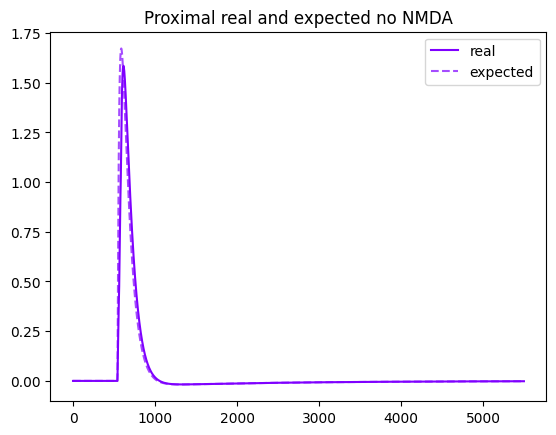

In [92]:
plt.plot(real,color = "#7F00FF",label="real")
plt.plot(expected,color="#7F00FF",linestyle = "dashed",alpha = 0.7,label="expected")
plt.legend()
plt.title("Proximal real and expected no NMDA")
plt.show()

#Distal Real

In [127]:

ampa_weight = 0.001
nmda_weight = ampa_weight*1.5

sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.67,
              "ampa_sec": 33,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.79,
              "nmda_sec": 33,

              "h_dt": 0.025,
              "h_tstop": 1000
              }

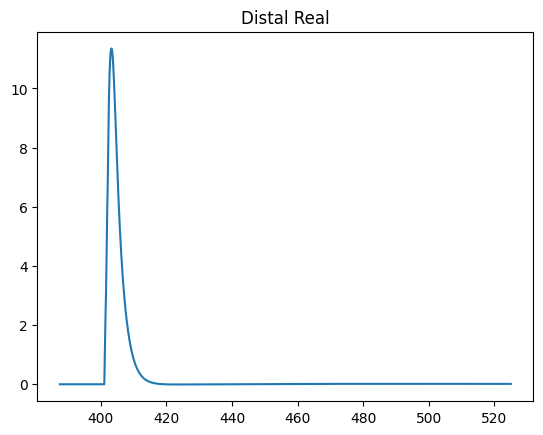

In [128]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
real = plot(rec_dict,"Distal Real","Real")

#Distal expected

In [122]:
nsyn_exc = int(40 *.04 * 2)
ampa_weight = 0.001
nmda_weight = ampa_weight*1.5
sim_params = {"event_times":[[400]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.67,
              "ampa_sec": 33,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.67,
              "nmda_sec": 33,

              "h_dt": 0.025,
              "h_tstop": 1000
              }

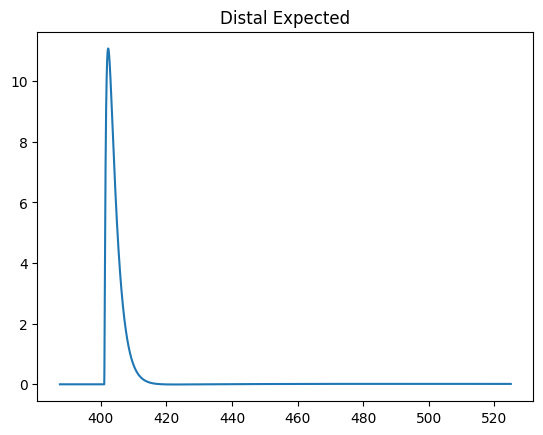

In [123]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
expected = plot(rec_dict,"Distal Expected","Expected")

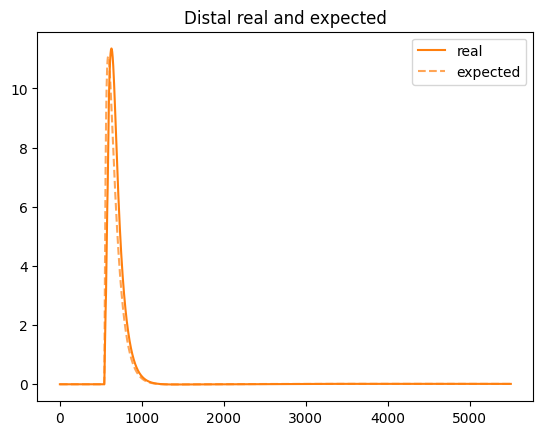

In [124]:
plt.plot(real,color = "#ff7f0e",label="real")
plt.plot(expected,color="#ff7f0e",linestyle = "dashed",alpha = 0.7,label="expected")
plt.legend()
plt.title("Distal real and expected")
plt.show()

#distal Real no nmda

In [111]:
ampa_weight = 0.001
nmda_weight = 0


sim_params = {"event_times":[[400], [400.5],[401]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.79,
              "ampa_sec": 33,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.79,
              "nmda_sec": 33,

              "h_dt": 0.025,
              "h_tstop": 1000
              }

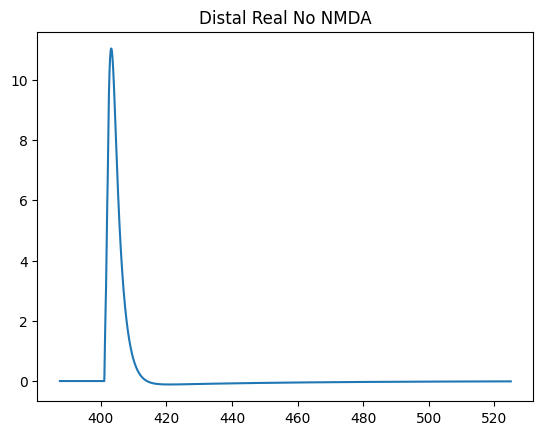

In [112]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
real = plot(rec_dict,"Distal Real No NMDA")

# Distal Expected No NMDA

In [113]:

ampa_weight = 0.001
nmda_weight = 0
sim_params = {"event_times":[[400]],
              "ampa_weight": ampa_weight,
              "ampa_point_proc": h.CPGLUIN,
              "ampa_seg": 0.79,
              "ampa_sec": 33,

              "nmda_weight": nmda_weight,
              "nmda_point_proc": h.NMDAIN,
              "nmda_seg": 0.79,
              "nmda_sec": 33,

              "h_dt": 0.025,
              "h_tstop": 1000
              }

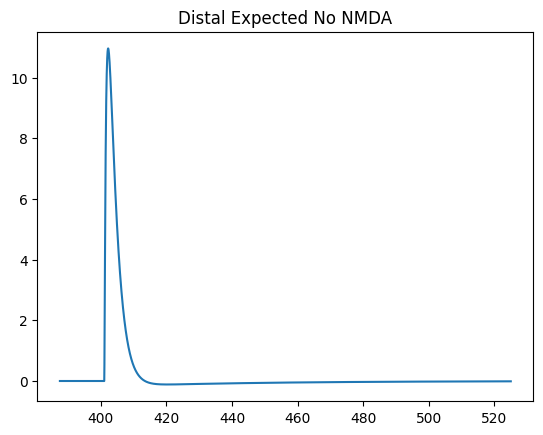

In [114]:
h = build_cell(6)#redifine/add ? to h so as to avoid run() conflict?
rec_dict= run(h,sim_params)
expected = plot(rec_dict,"Distal Expected No NMDA","Expected")

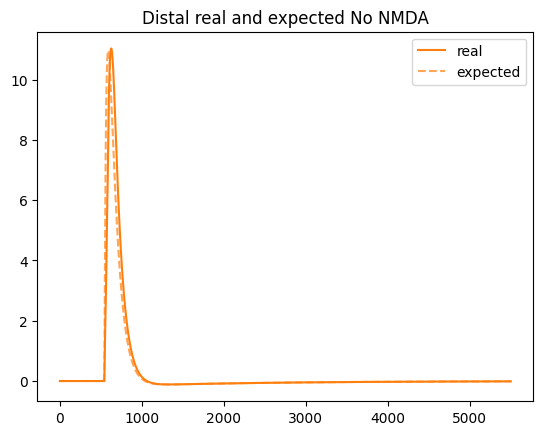

In [115]:
plt.plot(real,color = "#ff7f0e",label="real")
plt.plot(expected,color="#ff7f0e",linestyle = "dashed",alpha = 0.7,label="expected")
plt.legend()
plt.title("Distal real and expected No NMDA")
plt.show()